In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import timeseries_dataset_from_array

## Temperature forecasting
---

We will predict the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building.

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we’ll download is limited to 2009–2016.

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-07-21 17:28:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.163.88
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.163.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.7MB/s    in 0.7s    

2022-07-21 17:28:45 (18.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


As usual, looking through and understanding the data is recommended. 

In [3]:
df = pd.read_csv('/content/jena_climate_2009_2016.csv')  

df = df.drop(['Date Time'], axis=1)

print(df.head())
print(df.columns)
print(f'Total data points: {len(df)}')

   p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0    996.52     -8.02    265.40        -8.90    93.3          3.33   
1    996.57     -8.41    265.01        -9.28    93.4          3.23   
2    996.53     -8.51    264.91        -9.31    93.9          3.21   
3    996.51     -8.31    265.12        -9.07    94.2          3.26   
4    996.51     -8.27    265.15        -9.04    94.1          3.27   

   VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0          3.11          0.22       1.94             3.12       1307.75   
1          3.02          0.21       1.89             3.03       1309.80   
2          3.01          0.20       1.88             3.02       1310.24   
3          3.07          0.19       1.92             3.08       1309.19   
4          3.08          0.19       1.92             3.09       1309.00   

   wv (m/s)  max. wv (m/s)  wd (deg)  
0      1.03           1.75     152.3  
1      0.72           1.50     136.1  
2      0.19

We can plot the complete data for the temperature as follows:

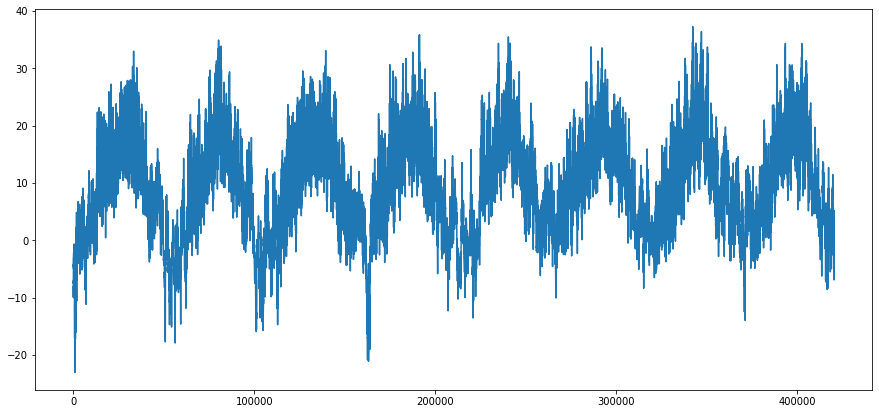

In [4]:
plt.figure(figsize=(15,7))
plt.plot(df['T (degC)'])

However, it may prove more useful to see only the first 10 days:

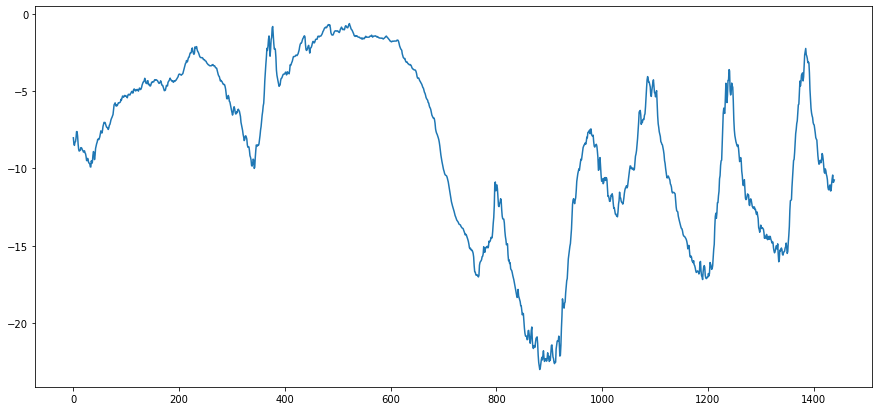

In [5]:
plt.figure(figsize=(15,7))
plt.plot(df['T (degC)'][:1440])

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale?

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

In [4]:
num_train_samples = int(0.5 * len(df))
num_val_samples = int(0.25 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

We’ll normalize each timeseries independently so that they all
take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [6]:
df_standard = (df - df.mean(axis=0)) / df.std(axis=0)

print(df.head())
print(df_standard[:5])

   p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0    996.52     -8.02    265.40        -8.90    93.3          3.33   
1    996.57     -8.41    265.01        -9.28    93.4          3.23   
2    996.53     -8.51    264.91        -9.31    93.9          3.21   
3    996.51     -8.31    265.12        -9.07    94.2          3.26   
4    996.51     -8.27    265.15        -9.04    94.1          3.27   

   VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0          3.11          0.22       1.94             3.12       1307.75   
1          3.02          0.21       1.89             3.03       1309.80   
2          3.01          0.20       1.88             3.02       1310.24   
3          3.07          0.19       1.92             3.08       1309.19   
4          3.08          0.19       1.92             3.09       1309.00   

   wv (m/s)  max. wv (m/s)  wd (deg)  
0      1.03           1.75     152.3  
1      0.72           1.50     136.1  
2      0.19

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample.

Instead, we’ll generate the samples on the fly while only keeping in memory the original data and temperature arrays, and nothing more.

There’s a built-in dataset utility in Keras that does just that -- timeseries_dataset_from_array().

We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for
training, one for validation, and one for testing. We’ll use the following parameter values:

- sampling_rate = 6—Observations will be sampled at one data point per hour:
we will only keep one data point out of 6.
- sequence_length = 120—Observations will go back 5 days (120 hours).
- delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence
will be the temperature 24 hours after the end of the sequence.

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = timeseries_dataset_from_array(
    df_standard[:-delay],
    targets=df_standard['T (degC)'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    df_standard[:-delay],
    targets=df_standard['T (degC)'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    df_standard[:-delay],
    targets=df_standard['T (degC)'][delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures. Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

### Predicting with a simple Neural Network

In [9]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(sequence_length, 14)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 27,185
Trainable params: 27,185
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, batch_size=32)

Epoch 1/10
819/819 [==============================] - 71s 83ms/step - loss: 0.1853 - mae: 0.3241 - val_loss: 0.1582 - val_mae: 0.3119
Epoch 2/10
819/819 [==============================] - 66s 80ms/step - loss: 0.1187 - mae: 0.2692 - val_loss: 0.1572 - val_mae: 0.3096
Epoch 3/10
819/819 [==============================] - 64s 78ms/step - loss: 0.1070 - mae: 0.2554 - val_loss: 0.2043 - val_mae: 0.3537
Epoch 4/10
819/819 [==============================] - 64s 77ms/step - loss: 0.0997 - mae: 0.2465 - val_loss: 0.1698 - val_mae: 0.3201
Epoch 5/10
819/819 [==============================] - 66s 80ms/step - loss: 0.0951 - mae: 0.2407 - val_loss: 0.1748 - val_mae: 0.3241
Epoch 6/10
819/819 [==============================] - 65s 79ms/step - loss: 0.0918 - mae: 0.2360 - val_loss: 0.1700 - val_mae: 0.3197
Epoch 7/10
819/819 [==============================] - 64s 77ms/step - loss: 0.0889 - mae: 0.2323 - val_loss: 0.1884 - val_mae: 0.3366
Epoch 8/10
819/819 [==============================] - 86s 105m

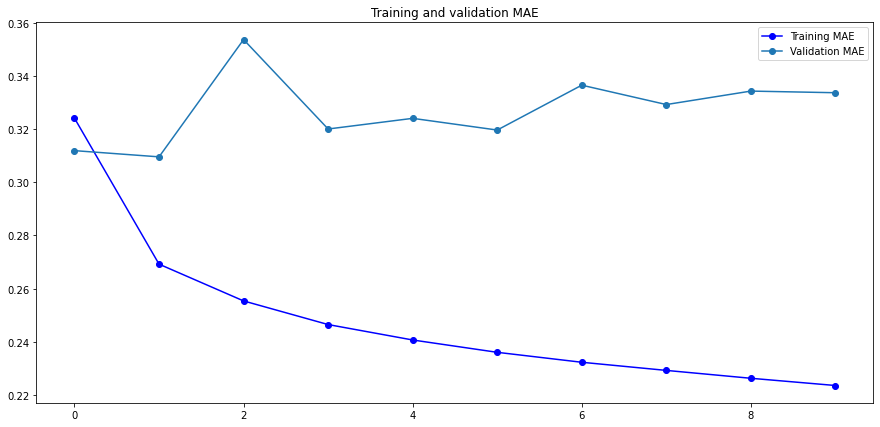

In [11]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

plt.figure(figsize=(15, 7))
plt.plot(loss, "bo-", label="Training MAE")
plt.plot(val_loss, "o-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

### Predicting with a Recurrent Neural Network

In [12]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(sequence_length, 14)))
model.add(layers.SimpleRNN(16))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset, batch_size=32)

Epoch 1/5
819/819 [==============================] - 85s 101ms/step - loss: 0.3191 - mae: 0.4257 - val_loss: 0.1444 - val_mae: 0.2975
Epoch 2/5
819/819 [==============================] - 84s 102ms/step - loss: 0.2159 - mae: 0.3597 - val_loss: 0.1350 - val_mae: 0.2872
Epoch 3/5
819/819 [==============================] - 84s 102ms/step - loss: 0.2134 - mae: 0.3575 - val_loss: 0.1341 - val_mae: 0.2868
Epoch 4/5
819/819 [==============================] - 84s 102ms/step - loss: 0.2128 - mae: 0.3571 - val_loss: 0.1322 - val_mae: 0.2825
Epoch 5/5
819/819 [==============================] - 84s 102ms/step - loss: 0.2118 - mae: 0.3560 - val_loss: 0.1323 - val_mae: 0.2839


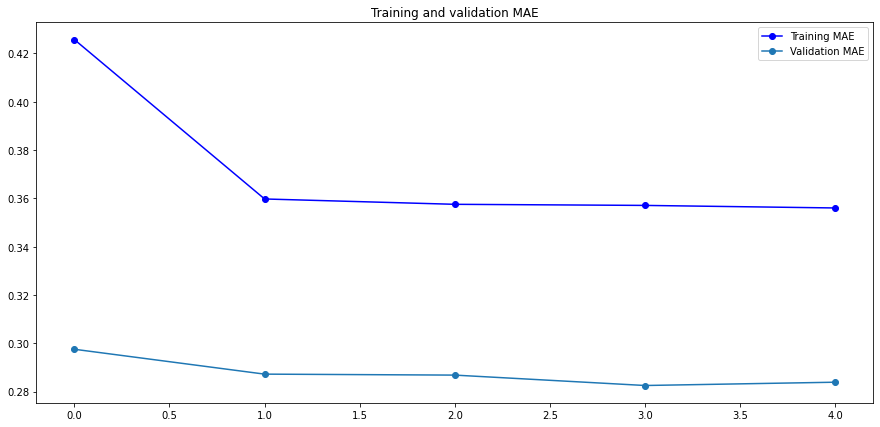

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]

plt.figure(figsize=(15, 7))
plt.plot(loss, "bo-", label="Training MAE")
plt.plot(val_loss, "o-", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

In [8]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(sequence_length, 14)))
model.add(layers.LSTM(32, recurrent_dropout=0.25))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset)

Epoch 1/10
819/819 [==============================] - 212s 255ms/step - loss: 0.2129 - mae: 0.3554 - val_loss: 0.1263 - val_mae: 0.2770
Epoch 2/10
819/819 [==============================] - 211s 257ms/step - loss: 0.1767 - mae: 0.3273 - val_loss: 0.1238 - val_mae: 0.2737
Epoch 3/10
819/819 [==============================] - 206s 251ms/step - loss: 0.1706 - mae: 0.3218 - val_loss: 0.1278 - val_mae: 0.2784
Epoch 4/10
819/819 [==============================] - 216s 263ms/step - loss: 0.1660 - mae: 0.3175 - val_loss: 0.1263 - val_mae: 0.2763
Epoch 5/10
819/819 [==============================] - 208s 254ms/step - loss: 0.1631 - mae: 0.3146 - val_loss: 0.1240 - val_mae: 0.2730
Epoch 6/10
819/819 [==============================] - 208s 253ms/step - loss: 0.1598 - mae: 0.3115 - val_loss: 0.1280 - val_mae: 0.2776
Epoch 7/10
819/819 [==============================] - 206s 251ms/step - loss: 0.1571 - mae: 0.3090 - val_loss: 0.1305 - val_mae: 0.2796
Epoch 8/10
819/819 [============================